This may be more readable [on NBViewer](http://nbviewer.ipython.org/github/tdhopper/stigler-diet/blob/master/content/articles/2015-07-30-sampling-from-a-hierarchical-dirichlet-process.ipynb).

In [137]:
%matplotlib inline

[As we saw earlier](http://stiglerdiet.com/blog/2015/Jul/28/dirichlet-distribution-and-dirichlet-process/) the Dirichlet process describes the _distribution_ of a random probability distribution. The Dirichlet process takes two parameters: a base distribution $H_0$ and a dispersion parameter $\alpha$. A sample from the Dirichlet process is itself a probability distribution that _looks like_ $H_0$. On average, the larger $\alpha$ is, the closer a sample from $\text{DP}(\alpha H_0)$ will be to $H_0$.

Suppose we're feeling masochistic and want to input a distribution sampled from a Dirichlet process as base distribution to a new Dirichlet process. (It will turn out that there are good reasons for this!) Conceptually this makes sense. But can we construct such a thing in practice? Said another way, can we build a sampler that will draw samples from a probability distribution drawn from these nested Dirichlet processes? We might initially try construct a sample (a probability distribution) from the first Dirichlet process before feeding it into the second.

But recall that fully constructing a sample (a probability distribution!) from a Dirichlet process would require drawing a countably infinite number of samples from $H_0$ and from the beta distribution to generate the weights. This would take forever, even with Hadoop!

[Dan Roy, et al](http://danroy.org/papers/RoyManGooTen-ICMLNPB-2008.pdf) helpfully described a technique of using _stochastic memoization_ to construct a distribution sampled from a Dirichlet process in a just-in-time manner. This process provides us with the equivalent of the [Scipy `rvs`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html) method for the sampled distribution.  Stochastic memoization is equivalent to the [Chinese restaurant process](http://www.cs.princeton.edu/courses/archive/fall07/cos597C/scribe/20070921.pdf): sometimes you get seated an an occupied table (i.e. sometimes you're given a sample you've seen before) and sometimes you're put at a new table (given a unique sample). 

Here is our memoization class again:

In [162]:
from numpy.random import choice 
from scipy.stats import beta

class DirichletProcessSample():
    def __init__(self, base_measure, alpha):
        self.base_measure = base_measure
        self.alpha = alpha
        
        self.cache = []
        self.weights = []
        self.total_stick_used = 0.

    def __call__(self):
        remaining = 1.0 - self.total_stick_used
        i = DirichletProcessSample.roll_die(self.weights + [remaining])
        if i is not None and i < len(self.weights) :
            return self.cache[i]
        else:
            stick_piece = beta(1, self.alpha).rvs() * remaining
            self.total_stick_used += stick_piece
            self.weights.append(stick_piece)
            new_value = self.base_measure()
            self.cache.append(new_value)
            return new_value
        
    @staticmethod 
    def roll_die(weights):
        if weights:
            return choice(range(len(weights)), p=weights)
        else:
            return None

Let's illustrate again with a standard normal base measure. We can construct a function `base_measure` that generates samples from it.

In [95]:
from scipy.stats import norm

base_measure = lambda: norm().rvs() 

Because the normal distribution has continuous support, we can generate samples from it forever and we will never see the same sample twice (in theory). We can illustrate this by drawing from the distribution ten thousand times and seeing that we get ten thousand unique values.

In [163]:
from pandas import Series

ndraws = 10000
print "Number of unique samples after {} draws:".format(ndraws), 
draws = Series([base_measure() for _ in range(ndraws)])
print draws.unique().size

Number of unique samples after 10000 draws: 10000


However, when we feed the base measure through the stochastic memoization procedure and then sample, we get many duplicate samples. The number of unique samples goes down as $\alpha$ increases.

In [164]:
norm_dp = DirichletProcessSample(base_measure, alpha=100)

print "Number of unique samples after {} draws:".format(ndraws), 
dp_draws = Series([norm_dp() for _ in range(ndraws)])
print dp_draws.unique().size

Number of unique samples after 10000 draws: 446


At this point, we have a function `dp_draws` that returns samples from a probability distribution (specifically, a probability distribution sampled from $\text{DP}(\alpha H_0)$). We can use `dp_draws` as a base distribution for another Dirichlet process!

In [155]:
norm_hdp = DirichletProcessSample(norm_dp, alpha=10)

How do we interpret this? `norm_dp` is a sampler from a probability distribution that looks like the standard normal distribution. `norm_hdp` is a sampler from a probability distribution that "looks like" the distribution `norm_dp` samples from. 

Here is a histogram of samples drawn from `norm_dp`, our first sampler.

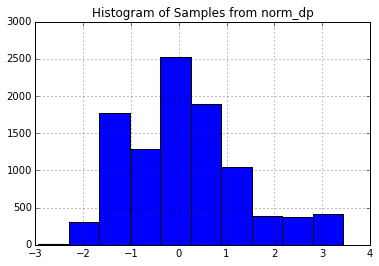

In [152]:
import matplotlib.pyplot as plt
pd.Series(norm_dp() for _ in range(10000)).hist()
_=plt.title("Histogram of Samples from norm_dp")

And here is a histogram for samples drawn from `norm_hdp`, our second sampler.

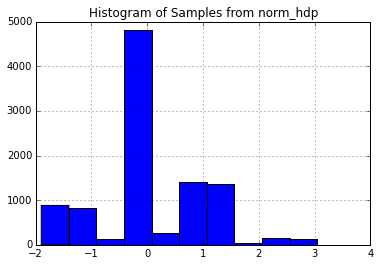

In [154]:
pd.Series(norm_hdp() for _ in range(10000)).hist()
_=plt.title("Histogram of Samples from norm_hdp")

The second plot doesn't look very much like the first! The level to which a sample from a Dirichlet process approximates the base distribution is a function of the dispersion parameter $\alpha$. Because I set $\alpha=10$ (which is relatively small), the approximation is fairly course. In terms of memoization, a small $\alpha$ value means the stochastic memoizer will more frequently reuse values already seen instead of drawing new ones.

This nesting procedure, where a sample from one Dirichlet process is fed into another Dirichlet process as a base distribution, is more than just a curiousity. It is known as a [Hierarchical Dirichlet Process, and it plays an important role in the study of Bayesian Nonparametrics](http://www.cs.berkeley.edu/~jordan/papers/hdp.pdf) (more on this in a future post). 

Without the stochastic memoization framework, constructing a sampler for a hierarchical Dirichlet process is a daunting task. We want to be able to draw samples from a distribution drawn from the second level Dirichlet process. However, to be able to do that, we need to be able to draw samples from a distribution sampled from a _base distribution of the second-level Dirichlet process_: this base distribution is a _distribution drawn from the first-level Dirichlet process_.

Though it appeared that we would need to be able to fully construct the first level sample (by drawing a countably infinite number of samples from the first-level base distribution). However, stochastic memoization allows us to only construct the first distribution just-in-time as it is needed at the second-level.

We can define a Python class to encapsulate the Hierarchical Dirichlet Process as a base class of the Dirichlet process.

In [165]:
class HierarchicalDirichletProcessSample(DirichletProcessSample):
    def __init__(self, base_measure, alpha1, alpha2):
        first_level_dp = DirichletProcessSample(base_measure, alpha1)
        self.second_level_dp = DirichletProcessSample(first_level_dp, alpha2)

    def __call__(self):
        return self.second_level_dp()

Since the Hierarchical DP is a Dirichlet Process inside of Dirichlet process, we must provide it with both a first and second level $\alpha$ value.

In [167]:
norm_hdp = HierarchicalDirichletProcessSample(base_measure, alpha1=10, alpha2=20)

We can sample directly from the probability distribution drawn from the Hierarchical Dirichlet Process.

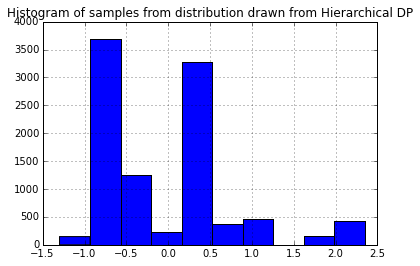

In [170]:
pd.Series(norm_hdp() for _ in range(10000)).hist()
_=plt.title("Histogram of samples from distribution drawn from Hierarchical DP")

`norm_hdp` is not equivalent to the Hierarchical Dirichlet Process; it samples from a _single distribution_ sampled from this HDP. Each time we instantiate the `norm_hdp` variable, we are getting a sampler for a unique distribution. Below we sample five times and get five different distributions.

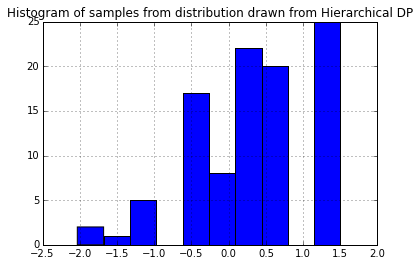

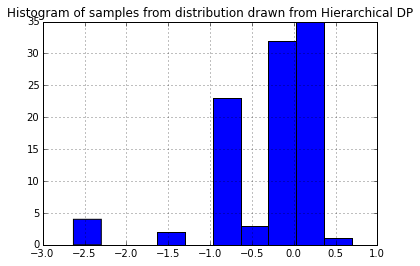

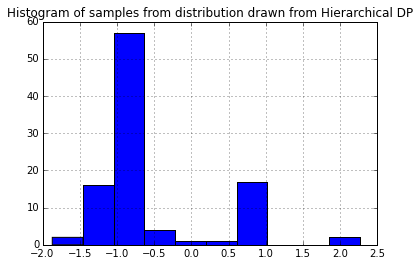

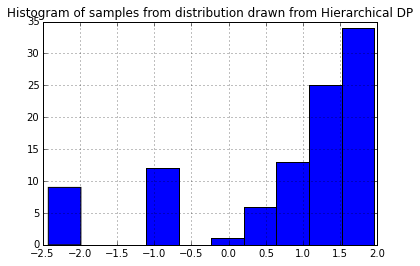

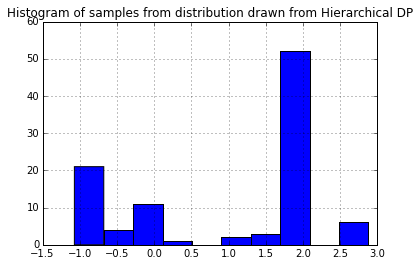

In [180]:
for i in range(5):
    norm_hdp = HierarchicalDirichletProcessSample(base_measure, alpha1=10, alpha2=10)
    _=pd.Series(norm_hdp() for _ in range(100)).hist()
    _=plt.title("Histogram of samples from distribution drawn from Hierarchical DP")
    _=plt.figure()

In a later post, I will discuss how these tools are applied in the realm of Bayesian nonparametrics.